# Convolutional Neural Networks Tutorial

In this notebook, you will:

- Implement helper functions that you will use when implementing a PyTorch model
- Implement a fully functioning ConvNet using PyTorch 

**After this assignment you will be able to:**

- Build and train a ConvNet in PyTorch for a classification problem 

## 1 - Outline of the Assignment

You will be implementing the building blocks of a convolutional neural network! Each function you will implement will have detailed instructions that will walk you through the steps needed:

- Convolution functions

- Pooling functions

    
In this next notebook, you will use the PyTorch equivalents of these functions to build the following model:

<img src="images/model.png" style="width:800px;height:300px;">

**Note** that for every forward function, there is its corresponding backward equivalent. Hence, at every step of your forward module you will store some parameters in a cache. These parameters are used to compute gradients during backpropagation. 

## 3 - Convolutional Neural Networks

Although programming frameworks make convolutions easy to use, they remain one of the hardest concepts to understand in Deep Learning. A convolution layer transforms an input volume into an output volume of different size, as shown below. 

<img src="images/conv_nn.png" style="width:350px;height:200px;">


### 3.1 - Zero-Padding

Zero-padding adds zeros around the border of an image:

<img src="images/PAD.png" style="width:600px;height:400px;">
<caption><center> <u> <font color='purple'> **Figure 1** </u><font color='purple'>  : **Zero-Padding**<br> Image (3 channels, RGB) with a padding of 2. </center></caption>

The main benefits of padding are the following:

- It allows you to use a CONV layer without necessarily shrinking the height and width of the volumes. This is important for building deeper networks, since otherwise the height/width would shrink as you go to deeper layers. An important special case is the "same" convolution, in which the height/width is exactly preserved after one layer. 

- It helps us keep more of the information at the border of an image. Without padding, very few values at the next layer would be affected by pixels as the edges of an image.


### 3.2 - Single step of convolution 

In this part, implement a single step of convolution, in which you apply the filter to a single position of the input. This will be used to build a convolutional unit, which: 

- Takes an input volume 
- Applies a filter at every position of the input
- Outputs another volume (usually of different size)

<img src="images/Convolution_schematic.gif" style="width:500px;">
<caption><center> <u> <font color='purple'> **Figure 2** </u><font color='purple'>  : **Convolution operation**<br> with a filter of 3x3 and a stride of 1 (stride = amount you move the window each time you slide) </center></caption>

In a computer vision application, each value in the matrix on the left corresponds to a single pixel value, and we convolve a 3x3 filter with the image by multiplying its values element-wise with the original matrix, then summing them up and adding a bias. In this first step of the exercise, you will implement a single step of convolution, corresponding to applying a filter to just one of the positions to get a single real-valued output. 


Below is a running demo of a CONV layer. Since 3D volumes are hard to visualize, all the volumes (the input volume (in blue), the weight volumes (in red), the output volume (in green)) are visualized with each depth slice stacked in rows. The input volume is of size W1=5, H1=5, D1=3, we have two filters of size 3×3, and they are applied with a stride of 2. 
<img src="images/mulinput.gif" style="width:600px;">

Reference：
<a href="http://cs231n.github.io/convolutional-networks/">http://cs231n.github.io/convolutional-networks/</a>

### 3.3 - Convolutional Neural Networks - Forward pass

In the forward pass, you will take many filters and convolve them on the input. Each 'convolution' gives you a 2D matrix output. You will then stack these outputs to get a 3D volume: 

<center>
<video width="620" height="440" src="images/conv_kiank.mp4" type="video/mp4" controls>
</video>
</center>


## 4 - Pooling layer 

The pooling (POOL) layer reduces the height and width of the input. It helps reduce computation, as well as helps make feature detectors more invariant to its position in the input. The two types of pooling layers are: 

- Max-pooling layer: slides an ($f, f$) window over the input and stores the max value of the window in the output.

- Average-pooling layer: slides an ($f, f$) window over the input and stores the average value of the window in the output.

<table>
<td>
<img src="images/max_pool1.png" style="width:500px;height:300px;">
<td>

<td>
<img src="images/a_pool.png" style="width:500px;height:300px;">
<td>
</table>

These pooling layers have no parameters for backpropagation to train. However, they have hyperparameters such as the window size $f$. This specifies the height and width of the fxf window you would compute a max or average over. 


The `ipynb` notebook and slides associated with <a href="http://deeplearning.ai">deeplearning.ai</a>

## 5 - PyTorch model

Most practical applications of deep learning today are built using programming frameworks, which have many built-in functions you can simply call. 

As usual, we will start by loading in the packages. 

In [1]:
import os
import argparse
import datetime
import torch
import torchtext.data as data
import torchtext.datasets as datasets
#import mydatasets
import numpy as np
import matplotlib.pyplot as plt

#dataset
import re
import random
import tarfile
import urllib
from torchtext import data

#model
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

#train
import sys
import torch.autograd as autograd

Run the next cell to add parameter.

In [2]:
#initial learning rate
lr = 0.001
#number of epochs for train
epochs =  50
#batch size for training
batch_size = 64
#how many steps to wait before logging training status
log_interval = 1
#how many steps to wait before testing
test_interval=50
#iteration numbers to stop without performance increasing
early_stop = 1000
# data 
#shuffle the data every epoch
shuffle = False
# model
#the probability for dropout
dropout = 0.5
#constraint of parameters
max_norm = 3.0
#number of embedding dimension
embed_dim = 128
#number of each kind of kernel
kernel_num =100
#comma-separated kernel size to use for convolution
kernel_sizes = '3,4,5'
#fix the embedding
static = False
# device
#device to use for iterate data, -1 mean cpu [default: -1]
device = -1
#disable the gpu
no_cuda = False
# option
#train or test
test = False

**Movie Review data from Rotten Tomatoes**
- Classify that the review is positive/negative
- Statistics
<img src="images/mrdataset.png" style="width:700px;">

**Preprocessing on text**
- Remove special symbol by regular expression
- Split sentence

Run the next cell to load the "movie review" dataset you are going to use.

As a reminder,the Movie Review data from Rotten Tomatoes classify that the review is positive/negative.

In [3]:
class MR(data.Dataset):

    @staticmethod
    def sort_key(ex):
        return len(ex.text)

    def __init__(self, text_field, label_field, path=None, examples=None, **kwargs):
       
        def clean_str(string):
            """
            Tokenization/string cleaning for all datasets except for SST.
            Original taken from https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
            """
            string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
            string = re.sub(r"\'s", " \'s", string)
            string = re.sub(r"\'ve", " \'ve", string)
            string = re.sub(r"n\'t", " n\'t", string)
            string = re.sub(r"\'re", " \'re", string)
            string = re.sub(r"\'d", " \'d", string)
            string = re.sub(r"\'ll", " \'ll", string)
            string = re.sub(r",", " , ", string)
            string = re.sub(r"!", " ! ", string)
            string = re.sub(r"\(", " \( ", string)
            string = re.sub(r"\)", " \) ", string)
            string = re.sub(r"\?", " \? ", string)
            string = re.sub(r"\s{2,}", " ", string)
            return string.strip()

        text_field.preprocessing = data.Pipeline(clean_str)
        fields = [('text', text_field), ('label', label_field)]

        if examples is None:
            path = self.dirname if path is None else path
            examples = []
            with open(os.path.join(path, 'rt-polarity.neg'), errors='ignore') as f:
                examples += [
                    data.Example.fromlist([line, 'negative'], fields) for line in f]
            with open(os.path.join(path, 'rt-polarity.pos'), errors='ignore') as f:
                examples += [
                    data.Example.fromlist([line, 'positive'], fields) for line in f]
        super(MR, self).__init__(examples, fields, **kwargs)

    @classmethod
    def splits(cls, text_field, label_field, dev_ratio=.1, shuffle=True, **kwargs):
        """Create dataset objects for splits of the MR dataset.

        Arguments:
            text_field: The field that will be used for the sentence.
            label_field: The field that will be used for label data.
            dev_ratio: The ratio that will be used to get split validation dataset.
            shuffle: Whether to shuffle the data before split.

        """
        path = "./rt-polaritydata/"
        examples = cls(text_field, label_field, path=path, **kwargs).examples
        if shuffle: random.shuffle(examples)
        dev_index = -1 * int(dev_ratio*len(examples))

        return (cls(text_field, label_field, examples=examples[:dev_index]),
                cls(text_field, label_field, examples=examples[dev_index:]))

In [4]:
# load MR dataset
def mr(text_field, label_field, **kargs):
    train_data, dev_data = MR.splits(text_field, label_field)
    text_field.build_vocab(train_data, dev_data)
    label_field.build_vocab(train_data, dev_data)
    train_iter, dev_iter = data.Iterator.splits(
                                (train_data, dev_data), 
                                batch_sizes=(batch_size, len(dev_data)),
                                **kargs)
    return train_iter, dev_iter

In [5]:
text_field = data.Field(lower=True)
label_field = data.Field(sequential=False)
train_iter, dev_iter = mr(text_field, label_field, device=-1, repeat=False)
# train_iter, dev_iter, test_iter = sst(text_field, label_field, device=-1, repeat=False)

In [6]:
embed_num = len(text_field.vocab)
class_num = len(label_field.vocab) - 1
cuda = (not no_cuda) and torch.cuda.is_available(); del no_cuda
kernel_sizes = [int(k) for k in kernel_sizes.split(',')]

## Model
The network we will build in this post looks roughly as follows:

<img src="images/textcnn.png" style="height:300px;">

The first layers embeds words into low-dimensional vectors. The next layer performs convolutions over the embedded word vectors using multiple filter sizes. For example, sliding over 3, 4 or 5 words at a time. Next, we max-pool the result of the convolutional layer into a long feature vector, add dropout regularization, and classify the result using a softmax layer, and we will not used pre-trained word2vec vectors for our word embeddings. Instead, we learn embeddings from scratch.

In [7]:
class CNN_Text(nn.Module):
    
    def __init__(self, lr,epochs,batch_size,log_interval,test_interval,early_stop,shuffle,dropout\
                 ,max_norm,embed_dim,kernel_num,kernel_sizes,static,device,no_cuda,test):
        super(CNN_Text, self).__init__()
        
        V = embed_num
        D = embed_dim
        C = class_num
        Ci = 1
        Co = kernel_num
        Ks = kernel_sizes
        
        self.embed = nn.Embedding(V, D)
        # self.convs1 = [nn.Conv2d(Ci, Co, (K, D)) for K in Ks]
        self.convs1 = nn.ModuleList([nn.Conv2d(Ci, Co, (K, D)) for K in Ks])
        '''
        self.conv13 = nn.Conv2d(Ci, Co, (3, D))
        self.conv14 = nn.Conv2d(Ci, Co, (4, D))
        self.conv15 = nn.Conv2d(Ci, Co, (5, D))
        '''
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(len(Ks)*Co, C)

    def conv_and_pool(self, x, conv):
        x = F.relu(conv(x)).squeeze(3)  # (N, Co, W)
        x = F.max_pool1d(x, x.size(2)).squeeze(2)
        return x

    def forward(self, x):
        x = self.embed(x)  # (N, W, D)
        
        if static:
            x = Variable(x)

        x = x.unsqueeze(1)  # (N, Ci, W, D)

        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs1]  # [(N, Co, W), ...]*len(Ks)

        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]  # [(N, Co), ...]*len(Ks)

        x = torch.cat(x, 1)

        '''
        x1 = self.conv_and_pool(x,self.conv13) #(N,Co)
        x2 = self.conv_and_pool(x,self.conv14) #(N,Co)
        x3 = self.conv_and_pool(x,self.conv15) #(N,Co)
        x = torch.cat((x1, x2, x3), 1) # (N,len(Ks)*Co)
        '''
        x = self.dropout(x)  # (N, len(Ks)*Co)
        logit = self.fc1(x)  # (N, C)
        return logit

## Train

In [8]:
def train(train_iter, dev_iter, model, lr,epochs,batch_size,log_interval,test_interval,early_stop,shuffle,dropout\
                 ,max_norm,embed_dim,kernel_num,kernel_sizes,static,device,no_cuda,test):
    if cuda:
        model.cuda()

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    steps = 0
    best_acc = 0
    last_step = 0
    accuracies = []
    model.train()
    for epoch in range(1, epochs+1):
        for batch in train_iter:
            feature, target = batch.text, batch.label
            feature.data.t_(), target.data.sub_(1)  # batch first, index align
            if cuda:
                feature, target = feature.cuda(), target.cuda()

            optimizer.zero_grad()
            logit = model(feature)

            #print('logit vector', logit.size())
            #print('target vector', target.size())
            loss = F.cross_entropy(logit, target)
            loss.backward()
            optimizer.step()

            steps += 1
            if steps % log_interval == 0:
                corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
                accuracy = 100.0 * corrects/batch.batch_size
                sys.stdout.write(
                    '\rBatch[{}] - loss: {:.6f}  acc: {:.4f}%({}/{})'.format(steps, 
                                                                             loss.data[0], 
                                                                             accuracy,
                                                                             corrects,
                                                                             batch.batch_size))
            if steps % test_interval == 0:
                dev_acc = eval(dev_iter, model, cuda)
                accuracies.append(dev_acc)
                if dev_acc > best_acc:
                    best_acc = dev_acc
                    last_step = steps
                else:
                    if steps - last_step >= early_stop:
                        print('early stop by {} steps.'.format(early_stop))

                
    # plot the cost
    plt.plot(np.squeeze(accuracies))
    plt.ylabel('acc')
    plt.xlabel('iterations')
    plt.title("Learning rate =" + str(lr))
    plt.show()


def eval(data_iter, model, cuda):
    model.eval()
    corrects, avg_loss = 0, 0
    for batch in data_iter:
        feature, target = batch.text, batch.label
        feature.data.t_(), target.data.sub_(1)  # batch first, index align
        if cuda:
            feature, target = feature.cuda(), target.cuda()

        logit = model(feature)
        loss = F.cross_entropy(logit, target, size_average=False)

        avg_loss += loss.data[0]
        corrects += (torch.max(logit, 1)
                     [1].view(target.size()).data == target.data).sum()
        
    size = len(data_iter.dataset)
    avg_loss /= size
    accuracy = 100.0 * corrects/size
    print('\nEvaluation - loss: {:.6f}  acc: {:.4f}%({}/{}) \n'.format(avg_loss, 
                                                                       accuracy, 
                                                                       corrects, 
                                                                       size))
    
    
    return accuracy


In [9]:
no_cuda = False
cnn = CNN_Text(lr,epochs,batch_size,log_interval,test_interval,early_stop,shuffle,dropout\
               ,max_norm,embed_dim,kernel_num,kernel_sizes,static,device,no_cuda,test)

if cuda:
    torch.cuda.set_device(device)
    cnn = cnn.cuda()

    

## CNN Structure

In [10]:
print(cnn)

CNN_Text(
  (embed): Embedding(21114, 128)
  (convs1): ModuleList(
    (0): Conv2d(1, 100, kernel_size=(3, 128), stride=(1, 1))
    (1): Conv2d(1, 100, kernel_size=(4, 128), stride=(1, 1))
    (2): Conv2d(1, 100, kernel_size=(5, 128), stride=(1, 1))
  )
  (dropout): Dropout(p=0.5)
  (fc1): Linear(in_features=300, out_features=2, bias=True)
)


/home/ginko/.local/lib/python3.5/site-packages/ipykernel_launcher.py:34: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Batch[50] - loss: 0.722820  acc: 54.0000%(35/64)
Evaluation - loss: 0.677804  acc: 55.0000%(593/1066) 

Batch[71] - loss: 0.703756  acc: 59.0000%(38/64)

/home/ginko/.local/lib/python3.5/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/home/ginko/.local/lib/python3.5/site-packages/ipykernel_launcher.py:69: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Batch[100] - loss: 0.676690  acc: 62.0000%(40/64)
Evaluation - loss: 0.661295  acc: 59.0000%(632/1066) 

Batch[150] - loss: 0.624592  acc: 70.0000%(42/60)
Evaluation - loss: 0.636103  acc: 64.0000%(690/1066) 

Batch[200] - loss: 0.458721  acc: 81.0000%(52/64)
Evaluation - loss: 0.621618  acc: 65.0000%(700/1066) 

Batch[250] - loss: 0.547412  acc: 75.0000%(48/64)
Evaluation - loss: 0.607533  acc: 68.0000%(725/1066) 

Batch[300] - loss: 0.486583  acc: 75.0000%(45/60)
Evaluation - loss: 0.606538  acc: 68.0000%(730/1066) 

Batch[350] - loss: 0.278782  acc: 90.0000%(58/64)
Evaluation - loss: 0.599041  acc: 70.0000%(748/1066) 

Batch[400] - loss: 0.292396  acc: 93.0000%(60/64)
Evaluation - loss: 0.606736  acc: 70.0000%(749/1066) 

Batch[450] - loss: 0.280801  acc: 86.0000%(52/60)
Evaluation - loss: 0.610323  acc: 69.0000%(744/1066) 

Batch[500] - loss: 0.079090  acc: 100.0000%(64/64)
Evaluation - loss: 0.624812  acc: 70.0000%(750/1066) 

Batch[550] - loss: 0.083433  acc: 100.0000%(64/64)
Eva

Batch[6600] - loss: 0.000031  acc: 100.0000%(60/60)
Evaluation - loss: 1.186060  acc: 71.0000%(763/1066) 

early stop by 1000 steps.
Batch[6650] - loss: 0.000034  acc: 100.0000%(64/64)
Evaluation - loss: 1.188515  acc: 71.0000%(763/1066) 

early stop by 1000 steps.
Batch[6700] - loss: 0.000029  acc: 100.0000%(64/64)
Evaluation - loss: 1.191008  acc: 71.0000%(763/1066) 

early stop by 1000 steps.
Batch[6750] - loss: 0.000028  acc: 100.0000%(60/60)
Evaluation - loss: 1.193768  acc: 71.0000%(764/1066) 

early stop by 1000 steps.
Batch[6800] - loss: 0.000032  acc: 100.0000%(64/64)
Evaluation - loss: 1.197046  acc: 71.0000%(763/1066) 

early stop by 1000 steps.
Batch[6850] - loss: 0.000025  acc: 100.0000%(64/64)
Evaluation - loss: 1.200081  acc: 71.0000%(764/1066) 

early stop by 1000 steps.
Batch[6900] - loss: 0.000027  acc: 100.0000%(60/60)
Evaluation - loss: 1.201997  acc: 71.0000%(763/1066) 

early stop by 1000 steps.
Batch[6950] - loss: 0.000028  acc: 100.0000%(64/64)
Evaluation - loss

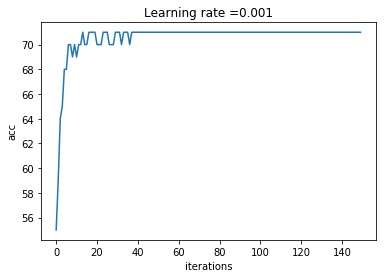

In [13]:
try:
    train(train_iter, dev_iter, cnn, lr,epochs,batch_size,log_interval,test_interval,early_stop,shuffle,dropout\
             ,max_norm,embed_dim,kernel_num,kernel_sizes,static,device,no_cuda,test)
except KeyboardInterrupt:
    print('\n' + '-' * 89)
    print('Exiting from training early')

Reference: <a href="https://github.com/Shawn1993/cnn-text-classification-pytorch">https://github.com/Shawn1993/cnn-text-classification-pytorch</a>